In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error


In [2]:
data = pd.read_csv('./feature_store/transformed_mutual_information.csv')

In [3]:
data.head

<bound method NDFrame.head of       morning_salinity  morning_pH  long_cycle  total_seed      area  \
0             3.178054    2.186051    4.727388   13.247532  8.510974   
1             3.178054    2.186051    4.804021   13.247532  8.510974   
2             3.178054    2.186051    3.688879   12.056708  6.685861   
3             3.178054    2.186051    4.553877   12.765691  7.901377   
4             3.178054    2.186051    4.553877   12.254868  6.938284   
...                ...         ...         ...         ...       ...   
2499          2.709258    2.206476    3.912023   11.156265  5.379897   
2500          3.178054    2.186051    3.496508   11.225257  7.688913   
2501          3.178054    2.186051    3.761200   10.191370  4.375757   
2502          2.801844    2.160349    4.343805   11.736077  6.803505   
2503          3.014718    2.182863    4.343805   11.736077  6.803505   

          size  num_of_harvest  
0     4.170534        1.609438  
1     4.174387        1.609438  
2     

In [4]:
X = data.drop(columns=['num_of_harvest']).values
y = data['num_of_harvest'].values

In [5]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [7]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_dim = X.shape[1]  # Jumlah fitur
hidden_dim = 64  # Ukuran layer tersembunyi
output_dim = 1  # Output tunggal (num_of_harvest)

model = MLP(input_dim, hidden_dim, output_dim)

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
def train_model(model, criterion, optimizer, X_train, y_train, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        
        optimizer.zero_grad()
        
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    return model

In [10]:
model = train_model(model, criterion, optimizer, X_train, y_train)

Epoch [10/100], Loss: 1.0435
Epoch [20/100], Loss: 0.4306
Epoch [30/100], Loss: 0.4831
Epoch [40/100], Loss: 0.3119
Epoch [50/100], Loss: 0.3303
Epoch [60/100], Loss: 0.3067
Epoch [70/100], Loss: 0.3081
Epoch [80/100], Loss: 0.3039
Epoch [90/100], Loss: 0.3017
Epoch [100/100], Loss: 0.2988


In [11]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

In [12]:
class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim, hidden_dim=50, output_dim=1, lr=0.001, num_epochs=100, optimizer_type='adam'):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lr = lr
        self.num_epochs = num_epochs
        self.optimizer_type = optimizer_type
        self.model = None
        self.criterion = nn.MSELoss()
        self.optimizer = None
    
    def _get_optimizer(self, model):
        if self.optimizer_type == 'adam':
            return optim.Adam(model.parameters(), lr=self.lr)
        elif self.optimizer_type == 'sgd':
            return optim.SGD(model.parameters(), lr=self.lr)
        elif self.optimizer_type == 'rmsprop':
            return optim.RMSprop(model.parameters(), lr=self.lr)
        elif self.optimizer_type == 'adagrad':
            return optim.Adagrad(model.parameters(), lr=self.lr)
        elif self.optimizer_type == 'adadelta':
            return optim.Adamax(model.parameters(), lr=self.lr)
        elif self.optimizer_type == 'adamax':
            return optim.NAdam(model.parameters(), lr=self.lr)
        elif self.optimizer_type == 'nadam':
            return optim.RMSprop(model.parameters(), lr=self.lr)
        else:
            raise ValueError(f"Unsupported optimizer type: {self.optimizer_type}")
    
    def fit(self, X, y):
        self.model = MLP(self.input_dim, self.hidden_dim, self.output_dim)
        self.optimizer = self._get_optimizer(self.model)
        
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
        
        self.model = train_model(self.model, self.criterion, self.optimizer, X_tensor, y_tensor, self.num_epochs)
        return self
    
    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            predictions = self.model(X_tensor).numpy()
        return predictions
    
    def score(self, X, y):
        y_pred = self.predict(X)
        y_true = y
        return -((y_pred - y_true) ** 2).mean()

In [13]:
param_grid = {
    'hidden_dim': [50, 100, 200],
    'lr': [0.001, 0.01, 0.1],
    'num_epochs': [100, 200],
    'optimizer_type': ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']
}

In [14]:
scorer = make_scorer(lambda y_true, y_pred: -((y_pred - y_true) ** 2).mean())
regressor = PyTorchRegressor(input_dim=input_dim)
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, scoring=scorer, cv=3)

In [15]:
grid_search.fit(X_train.numpy(), y_train.numpy())

Epoch [10/100], Loss: 0.3904
Epoch [20/100], Loss: 0.5005
Epoch [30/100], Loss: 0.3760
Epoch [40/100], Loss: 0.3788
Epoch [50/100], Loss: 0.3677
Epoch [60/100], Loss: 0.3569
Epoch [70/100], Loss: 0.3499
Epoch [80/100], Loss: 0.3441
Epoch [90/100], Loss: 0.3385
Epoch [100/100], Loss: 0.3329
Epoch [10/100], Loss: 0.3981
Epoch [20/100], Loss: 0.3608
Epoch [30/100], Loss: 0.3585
Epoch [40/100], Loss: 0.3362
Epoch [50/100], Loss: 0.3267
Epoch [60/100], Loss: 0.3196
Epoch [70/100], Loss: 0.3137
Epoch [80/100], Loss: 0.3082
Epoch [90/100], Loss: 0.3030
Epoch [100/100], Loss: 0.2982
Epoch [10/100], Loss: 0.3482
Epoch [20/100], Loss: 0.4829
Epoch [30/100], Loss: 0.3411
Epoch [40/100], Loss: 0.3508
Epoch [50/100], Loss: 0.3374
Epoch [60/100], Loss: 0.3319
Epoch [70/100], Loss: 0.3293
Epoch [80/100], Loss: 0.3241
Epoch [90/100], Loss: 0.3202
Epoch [100/100], Loss: 0.3160
Epoch [10/100], Loss: 0.2701
Epoch [20/100], Loss: 0.2695
Epoch [30/100], Loss: 0.2688
Epoch [40/100], Loss: 0.2682
Epoch [50/1

GridSearchCV(cv=3, estimator=PyTorchRegressor(input_dim=6),
             param_grid={'hidden_dim': [50, 100, 200], 'lr': [0.001, 0.01, 0.1],
                         'num_epochs': [100, 200],
                         'optimizer_type': ['adam', 'sgd', 'rmsprop', 'adagrad',
                                            'adadelta', 'adamax', 'nadam']},
             scoring=make_scorer(<lambda>, response_method='predict'))

In [16]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [17]:
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'hidden_dim': 200, 'lr': 0.01, 'num_epochs': 200, 'optimizer_type': 'adam'}
Best score: -0.21170738339424133


In [18]:
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test.numpy())

In [19]:
mae, rmse = calculate_metrics(y_test.numpy(), y_test_pred)
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 0.3767
RMSE: 0.4672


In [20]:
import matplotlib.pyplot as plt

In [21]:
def plot_regression_results(y_true, y_pred):
    
    # Plot predicted vs true values
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, edgecolor='k', alpha=0.7)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')

    # Plot the residuals/errors
    residuals = y_true - y_pred
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals, edgecolor='k', alpha=0.7)
    plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='dashed')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted')

    plt.tight_layout()
    plt.show()


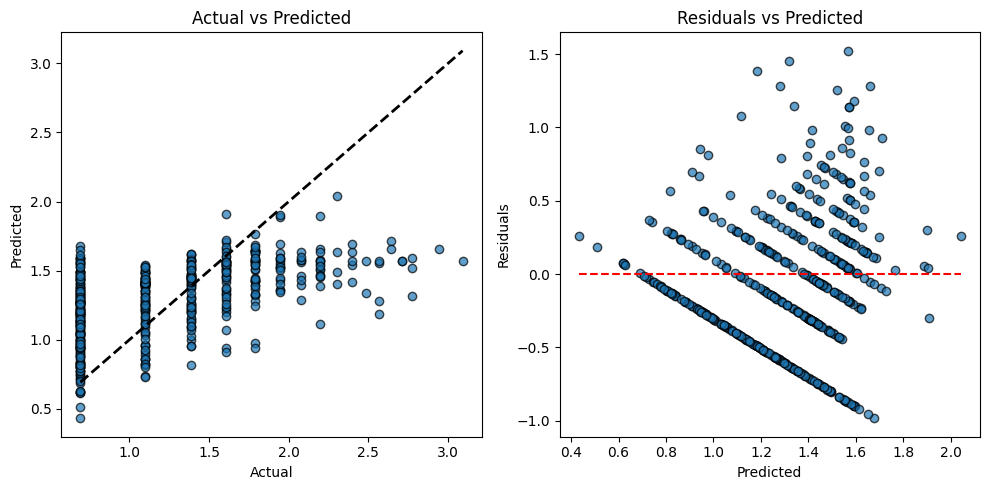

In [22]:
plot_regression_results(y_test.numpy(), y_test_pred)